In [1]:
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import hashlib
from env import *
import matplotlib.pyplot as plt
import pandas as pd
import csv
import googlemaps


### get values from env file
username = USERNAME
password = PASSWORD
api_key = MAPS_API_KEY

In [2]:
def getData(blocks, my_class):
    if my_class  in ['start-date', 'end-date', 'duration']:
        text_class = 'text-small'
    else:
        text_class = 'text-large'
    
    values = []
    
    for block in blocks:
        this_block = block.find_all(class_=my_class)
        block_text = this_block[0].find('div', class_=text_class)
        value = block_text.text.strip()
        values.append(value)
    
    return values

def dateStrToDate(my_str):
    date_format = '%m-%d-%Y %H:%M:%S'
    my_date = datetime.strptime(my_str, date_format)
    return my_date

def getTripId(trip_block):
    hash_object = hashlib.sha256()
    hash_object.update(trip_block.encode('utf-8'))
    # Get the hexadecimal representation of the hash
    trip_id = hash_object.hexdigest()

    return trip_id

def parse_duration(duration_str):
    # Split the duration string into hours, minutes, and seconds
    hours, minutes, seconds = map(int, duration_str.split(':'))
    
    # Calculate the total duration in seconds
    total_seconds = hours * 3600 + minutes * 60 + seconds
    
    return total_seconds

def format_duration(total_seconds):
    # Calculate hours, minutes, and seconds from total seconds
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    # Format as HH:MM:SS
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"



In [3]:
### GET XSRF Token

url = "https://members.bikesharetoronto.com/login"

payload = {}
headers = {
  'authority': 'members.bikesharetoronto.com',
  'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
  'accept-language': 'en,es-419;q=0.9,es;q=0.8,en-US;q=0.7',
  'referer': 'https://bikesharetoronto.com/',
  'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36',
}

response = requests.request("GET", url, headers=headers, data=payload)

### Parse the HTML content

# Get cookies
cookies = response.cookies
xsrf_token = cookies['XSRF-TOKEN'].replace('%3D', "")
laravel_session = cookies['laravel_session']

# Get HTML content
html_content = response.text
soup = BeautifulSoup(html_content, 'html.parser')

# Extract the CSRF token value for the login request
csrf_meta_tag = soup.find('meta', attrs={'name': 'csrf-token'})
csrf_token = csrf_meta_tag.get('content')

In [4]:
### Login

import requests

url = "https://members.bikesharetoronto.com/login"

payload = '_token=' + csrf_token + '&userName=' + username + '&password=' + password
headers = {
  'authority': 'members.bikesharetoronto.com',
  'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
  'accept-language': 'en,es-419;q=0.9,es;q=0.8,en-US;q=0.7',
  'cache-control': 'max-age=0',
  'content-type': 'application/x-www-form-urlencoded',
  'origin': 'https://members.bikesharetoronto.com',
  'referer': 'https://members.bikesharetoronto.com/login',
  'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/117.0.0.0 Safari/537.36',
  'Cookie': 'XSRF-TOKEN=' + xsrf_token + '; laravel_session=' + laravel_session
}

response = requests.request("POST", url, headers=headers, data=payload)

# Update cookies
cookies = response.cookies
xsrf_token = cookies['XSRF-TOKEN'].replace('%3D', "")
laravel_session = cookies['laravel_session']

In [5]:
### BIKE SHARE TRIPS API CALL
def getTripsAPI(trip_dict, start_date, end_date, xsrf_token, laravel_session):
    new_trip_dict = {}
    
    url = "https://members.bikesharetoronto.com/trips?period=custom&date%5Bstart%5D=" + start_date + "&date%5Bend%5D=" + end_date + '&sort_direction=asc&sort_by=endTime'

    payload = {}
    headers = {
      'authority': 'members.bikesharetoronto.com',
      'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
      'accept-language': 'en,es-419;q=0.9,es;q=0.8,en-US;q=0.7',
      'referer': 'https://members.bikesharetoronto.com/trips',
      'Cookie': 'XSRF-TOKEN=' + xsrf_token + '; laravel_session=' + laravel_session
    }

    response = requests.request("GET", url, headers=headers, data=payload)
    html_content = response.text

    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')
    
    new_trip_dict = parseTrips(soup)
    
    # Combine add new trips to existing dict
    trip_dict.update(new_trip_dict)

    return trip_dict

### HELPER FUNCTIONS - HTML PARSING
def parseTrips(soup):
    
    ## Parse HTML to get data
    trip_blocks = soup.find_all(class_='trip-block')

    start_dates = getData(trip_blocks, 'start-date')
    end_dates = getData(trip_blocks, 'end-date')
    durations = getData(trip_blocks, 'duration')
    start_stations= getData(trip_blocks, 'start-station-name-block')
    end_stations = getData(trip_blocks, 'end-station-name-block')

    ## Convert to datetime
    if len(start_dates) != len(end_dates):
        print("Error - different length of start and end dates")
    else:
        for i in range(len(start_dates)):
            start_date = dateStrToDate(start_dates[i])
            start_dates[i] = start_date

            end_date = dateStrToDate(end_dates[i])
            end_dates[i] = end_date

            duration_in_seconds = parse_duration(durations[i])
            durations[i] = duration_in_seconds
    
    new_trip_dict = {}

    for i in range(len(start_dates)):
        trip_id = getTripId(trip_blocks[i])
        new_trip_dict[trip_id] = {
            "start_date": start_dates[i],
            "end_date": end_dates[i],
            "duration": durations[i],
            "start_station": start_stations[i],
            "end_station": end_stations[i]
        }
    
    return new_trip_dict


### HELPER FUNCTIONS - GET MIN START DATE
def find_minimum_start_date(trip_dict):
    start_dates = [trip_info['start_date'] for trip_info in trip_dict.values()]
    min_start_date = min(start_dates)

    return min_start_date


### GOOGLE MAPS API CALL
def getRouteDistanceOnBike(start_lat, start_lon, end_lat, end_lon):
    # Initialize the Google Maps client
    gmaps = googlemaps.Client(key=api_key)

    # Define the starting and ending coordinates (latitude and longitude)    
    start_location = (start_lat, start_lon)
    end_location = (end_lat, end_lon)

    # Specify the mode of travel as 'bicycling'
    mode = 'bicycling'

    directions_result = gmaps.directions(
       start_location,
       end_location,
       mode=mode,
       departure_time=datetime.now()
    )

    # Extract the total distance in meters from the result
    distance_meters = directions_result[0]['legs'][0]['distance']['value']
    return distance_meters


In [6]:
### GET TRIPS 

# Pick an arbitrary date from a long time ago
start_date = '01-01-2015'
end_date = '27-09-2023'

trip_dict = {}
new_trip_dict = {}

new_trip_dict = getTripsAPI(trip_dict, start_date, end_date, xsrf_token, laravel_session)
trip_dict = new_trip_dict

# Get minimum date in trip_dict and iterate until it no new rides are found
min_date = find_minimum_start_date(trip_dict)
new_end_date = min_date.strftime('%d-%m-%Y')

start_time = datetime.now()

while True:

    min_date = find_minimum_start_date(trip_dict)
    new_end_date = min_date.strftime('%d-%m-%Y')
    
    prev_trip_dict_len = len(trip_dict)

    new_trip_dict = getTripsAPI(trip_dict, start_date, new_end_date, xsrf_token, laravel_session)
    trip_dict = new_trip_dict
    
    update_trip_dict_len = len(trip_dict)
    
    print(update_trip_dict_len)
    
    if update_trip_dict_len == prev_trip_dict_len:
        break

end_time = datetime.now()
time_to_complete = end_time - start_time
print(time_to_complete)

98
145
194
242
291
337
384
432
481
529
573
621
670
717
763
811
859
907
937
937
0:00:57.520880


In [7]:
### Get total ride time

total_seconds = 0

for key, value in trip_dict.items():
    total_seconds += trip_dict[key]['duration']


format_duration(total_seconds)

'125:35:33'

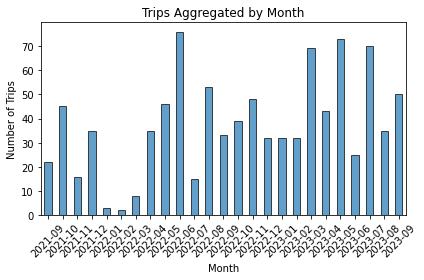

In [8]:
### Plot rides over time

# Extract and format the start_date values into a list of months
start_dates = [trip_info['start_date'] for trip_info in trip_dict.values()]
months = [date.strftime('%Y-%m') for date in start_dates]
df = pd.DataFrame({'Months': months})

# Count the occurrences of each month and sort by month
month_counts = df['Months'].value_counts().sort_index()

# Create a bar plot of the month counts
month_counts.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Trips Aggregated by Month')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [9]:
# ### Plot rides by month in table from

# month_counts = df.groupby('Months').size().reset_index(name='Count')
# month_counts

In [10]:
### GET STATION LOCATIONS

start_stations = [trip_info['start_station'] for trip_info in trip_dict.values()]
start_stations

url = 'https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information'

res = requests.get(url).json()
stations = res['data']['stations']

In [ ]:
# #### EXOPRT STATIONS TO CSV




# # Sample list of dictionaries

# # Define the CSV file name
# csv_file = 'stations.csv'

# all_keys = set(key for item in stations for key in item.keys())

# # Write the list of dictionaries to a CSV file
# with open(csv_file, mode='w', newline='') as file:
#     writer = csv.DictWriter(file, fieldnames=all_keys)
    
#     # Write the header
#     writer.writeheader()
    
#     # Write the data rows
#     for row in stations:
#         # Create a new dictionary with all possible keys, setting default values to None
#         new_row = {key: row.get(key, None) for key in all_keys}
#         writer.writerow(new_row)

# print(f'CSV file "{csv_file}" has been created.')

In [11]:
### ADD LAT AND LON OF START AND END STATIONS, WHILE KEEPING TRACK OF LOCATIONS THAT AREN'T FOUND

unmatched_trip_ids = []
unmatched_station_names = []

for trip_id, trip_info in trip_dict.items():
    start_station_name = trip_info['start_station']
    end_station_name = trip_info['end_station']

    # Find the matching station by name (since names are unique)
    matching_start_station = next((station for station in stations if station['name'] == start_station_name), None)
    matching_end_station = next((station for station in stations if station['name'] == end_station_name), None)

    if matching_start_station:
        # Add lat and lon to the trip_dict
        trip_info['start_lat'] = matching_start_station['lat']
        trip_info['start_lon'] = matching_start_station['lon']
    else:
        unmatched_trip_ids.append(trip_id)
        unmatched_station_names.append(start_station_name)
        
    if matching_end_station:
        # Add lat and lon to the trip_dict
        trip_info['end_lat'] = matching_end_station['lat']
        trip_info['end_lon'] = matching_end_station['lon']
    else:
        unmatched_trip_ids.append(trip_id)
        unmatched_station_names.append(end_station_name)

In [12]:
# unique_unmatched_stations =list(set(unmatched_station_names))
# unique_unmatched_stations

In [13]:
manual_lookup = {
    'Princess St / Adelaide St E': {
        'lat': 43.652246, 
        'lon': -79.367226
    },
    'Adelaide St W / Bay St - SMART': {
        'lat': 43.650207, 
        'lon': -79.379938
    },
    'Bloor St W / Huron St': {
        'lat': 43.667007, 
        'lon': -79.401706
    },
    'Martin Goodman Trail / Remembrance Dr': {
        'lat': 43.635495,
        'lon': -79.4035221
    },
    'Simcoe St / Adelaide St W': {
        'lat': 43.648515, 
        'lon':-79.386461
    },
    'Avenue Rd / Cumberland St': {
        'lat': 43.6698217,
        'lon': -79.39444615
    },
    'Dundas St E / Victoria St': {
        'lat': 43.6566482,
        'lon': -79.3797481
    },
    "D'Arcy St / Spadina Ave - SMART": {
        'lat': 43.6540496,
        'lon': -79.3982009
    },
    'Adelaide St W / Portland St': {
        'lat': 43.645618,
        'lon': -79.400459
    },
    'Fennings St / Queen St W': {
        'lat': 43.643833,
        'lon': -79.421123
    },
    'Widmer St / Adelaide St W': {
        'lat': 43.6472947,
        'lon': -79.3915765
    },
    'Stewart St / Bathurst St  - SMART': {
        'lat': 43.643317, 
        'lon': -79.402075
    },
    'Queen St E / George St (Moss Park)': {
        'lat': 43.654208,
        'lon': -79.372065
    },
    'Wellington St W / Portland St': {
        'lat': 43.643044,
        'lon': -79.399596
    },
    'Fleet St / Garrison Rd (Fort York)': {
        'lat': 43.636882,
        'lon': -79.408826
    },
    'Foster Pl / Elizabeth St': {
        'lat': 43.654550,
        'lon': -79.384645
    },
    'Queen St W / James St': {
        'lat': 43.6524891,
        'lon': -79.3807605
 }
}

In [14]:
### CHECK FOR TRIPS WITH A NULL END STATION, AND DELETE THEM, PRINTING IDS BEING DELETED
empty_end_trips = {trip_id: trip_info for trip_id, trip_info in trip_dict.items() if trip_info['end_station'] == ''}
empty_end_trips

for key in empty_end_trips:
    key_to_delete = key
    try:
        trip_dict.pop(key_to_delete, None)
        print(key_to_delete)
    except:
        continue


e55a246c46593e9fbc50e1bf93aacc815aadb047698d9f9c143633720cdb003a


In [15]:
unmatched_trip_dict = {trip_id: trip_info for trip_id, trip_info in trip_dict.items() if trip_id in unmatched_trip_ids}

In [16]:
for trip_id, trip_info in unmatched_trip_dict.items():
    
    if 'start_lat' not in unmatched_trip_dict[trip_id]:
        start_station = unmatched_trip_dict[trip_id]['start_station']
        trip_dict[trip_id]['start_lat'] = manual_lookup[start_station]['lat']
        trip_dict[trip_id]['start_lon'] = manual_lookup[start_station]['lon']
        
    if 'end_lat' not in unmatched_trip_dict[trip_id]:
        end_station = unmatched_trip_dict[trip_id]['end_station']
        trip_dict[trip_id]['end_lat'] = manual_lookup[end_station]['lat']
        trip_dict[trip_id]['end_lon'] = manual_lookup[end_station]['lon']

In [18]:
### ADD DISTANCE IN METERS
start_time = datetime.now()

for key, value in trip_dict.items():
    start_lat = trip_dict[key]['start_lat']
    start_lon = trip_dict[key]['start_lon']
    end_lat = trip_dict[key]['end_lat']
    end_lon = trip_dict[key]['end_lon']
    
    bike_dist = getRouteDistanceOnBike(start_lat, start_lon, end_lat, end_lon)
    
    trip_dict[key]['bike_dist'] = bike_dist
    
    speed_ms = bike_dist / trip_dict[key]['duration']
    speed_kmh = speed_ms * 3.6
    trip_dict[key]['speed'] = speed_kmh

end_time = datetime.now()
time_to_complete = end_time - start_time
print(time_to_complete)

Total bike route distance in meters: 424 meters
424
Total bike route distance in meters: 1282 meters
1282
Total bike route distance in meters: 4053 meters
4053
Total bike route distance in meters: 2980 meters
2980
Total bike route distance in meters: 3560 meters
3560
Total bike route distance in meters: 3929 meters
3929
Total bike route distance in meters: 4979 meters
4979
Total bike route distance in meters: 3929 meters
3929
Total bike route distance in meters: 1794 meters
1794
Total bike route distance in meters: 1508 meters
1508
Total bike route distance in meters: 3560 meters
3560
Total bike route distance in meters: 3929 meters
3929
Total bike route distance in meters: 3271 meters
3271
Total bike route distance in meters: 4195 meters
4195
Total bike route distance in meters: 3845 meters
3845
Total bike route distance in meters: 3873 meters
3873
Total bike route distance in meters: 3560 meters
3560
Total bike route distance in meters: 1153 meters
1153
Total bike route distance in m

Total bike route distance in meters: 2494 meters
2494
Total bike route distance in meters: 1124 meters
1124
Total bike route distance in meters: 3929 meters
3929
Total bike route distance in meters: 805 meters
805
Total bike route distance in meters: 847 meters
847
Total bike route distance in meters: 886 meters
886
Total bike route distance in meters: 830 meters
830
Total bike route distance in meters: 5626 meters
5626
Total bike route distance in meters: 3929 meters
3929
Total bike route distance in meters: 916 meters
916
Total bike route distance in meters: 5397 meters
5397
Total bike route distance in meters: 2245 meters
2245
Total bike route distance in meters: 3568 meters
3568
Total bike route distance in meters: 419 meters
419
Total bike route distance in meters: 2640 meters
2640
Total bike route distance in meters: 3929 meters
3929
Total bike route distance in meters: 1170 meters
1170
Total bike route distance in meters: 1645 meters
1645
Total bike route distance in meters: 205

Total bike route distance in meters: 356 meters
356
Total bike route distance in meters: 1517 meters
1517
Total bike route distance in meters: 2908 meters
2908
Total bike route distance in meters: 999 meters
999
Total bike route distance in meters: 1290 meters
1290
Total bike route distance in meters: 1025 meters
1025
Total bike route distance in meters: 2207 meters
2207
Total bike route distance in meters: 847 meters
847
Total bike route distance in meters: 830 meters
830
Total bike route distance in meters: 1794 meters
1794
Total bike route distance in meters: 1639 meters
1639
Total bike route distance in meters: 633 meters
633
Total bike route distance in meters: 2309 meters
2309
Total bike route distance in meters: 2308 meters
2308
Total bike route distance in meters: 380 meters
380
Total bike route distance in meters: 1143 meters
1143
Total bike route distance in meters: 2189 meters
2189
Total bike route distance in meters: 342 meters
342
Total bike route distance in meters: 3929 

Total bike route distance in meters: 1084 meters
1084
Total bike route distance in meters: 2046 meters
2046
Total bike route distance in meters: 1627 meters
1627
Total bike route distance in meters: 1552 meters
1552
Total bike route distance in meters: 1475 meters
1475
Total bike route distance in meters: 2783 meters
2783
Total bike route distance in meters: 3731 meters
3731
Total bike route distance in meters: 1188 meters
1188
Total bike route distance in meters: 1666 meters
1666
Total bike route distance in meters: 1541 meters
1541
Total bike route distance in meters: 1486 meters
1486
Total bike route distance in meters: 3148 meters
3148
Total bike route distance in meters: 9670 meters
9670
Total bike route distance in meters: 3311 meters
3311
Total bike route distance in meters: 2481 meters
2481
Total bike route distance in meters: 607 meters
607
Total bike route distance in meters: 2093 meters
2093
Total bike route distance in meters: 2340 meters
2340
Total bike route distance in m

2329
Total bike route distance in meters: 1497 meters
1497
Total bike route distance in meters: 805 meters
805
Total bike route distance in meters: 805 meters
805
Total bike route distance in meters: 1645 meters
1645
Total bike route distance in meters: 1444 meters
1444
Total bike route distance in meters: 4389 meters
4389
Total bike route distance in meters: 1658 meters
1658
Total bike route distance in meters: 805 meters
805
Total bike route distance in meters: 2791 meters
2791
Total bike route distance in meters: 605 meters
605
Total bike route distance in meters: 1658 meters
1658
Total bike route distance in meters: 1906 meters
1906
Total bike route distance in meters: 805 meters
805
Total bike route distance in meters: 830 meters
830
Total bike route distance in meters: 0 meters
0
Total bike route distance in meters: 805 meters
805
Total bike route distance in meters: 830 meters
830
Total bike route distance in meters: 491 meters
491
Total bike route distance in meters: 771 meters

Total bike route distance in meters: 4252 meters
4252
Total bike route distance in meters: 4077 meters
4077
Total bike route distance in meters: 2056 meters
2056
Total bike route distance in meters: 805 meters
805
Total bike route distance in meters: 751 meters
751
Total bike route distance in meters: 886 meters
886
Total bike route distance in meters: 1794 meters
1794
Total bike route distance in meters: 1639 meters
1639
Total bike route distance in meters: 2211 meters
2211
Total bike route distance in meters: 2308 meters
2308
Total bike route distance in meters: 1189 meters
1189
Total bike route distance in meters: 805 meters
805
Total bike route distance in meters: 1189 meters
1189
Total bike route distance in meters: 805 meters
805
Total bike route distance in meters: 627 meters
627
Total bike route distance in meters: 1491 meters
1491
Total bike route distance in meters: 805 meters
805
Total bike route distance in meters: 1330 meters
1330
Total bike route distance in meters: 971 m

1639
Total bike route distance in meters: 1427 meters
1427
Total bike route distance in meters: 1904 meters
1904
Total bike route distance in meters: 1568 meters
1568
Total bike route distance in meters: 3001 meters
3001
Total bike route distance in meters: 1521 meters
1521
Total bike route distance in meters: 2482 meters
2482
Total bike route distance in meters: 2481 meters
2481
Total bike route distance in meters: 0 meters
0
Total bike route distance in meters: 0 meters
0
Total bike route distance in meters: 0 meters
0
0:01:59.223699


In [19]:
### Get total ride distance

total_dist = 0

for key, value in trip_dict.items():
    total_dist += trip_dict[key]['bike_dist']


print(total_dist)

1835918


In [20]:

# Extract the 'start_date' and 'bike_dist' values into lists
start_dates = [trip_info['start_date'] for trip_info in trip_dict.values()]
bike_dists = [trip_info['bike_dist'] for trip_info in trip_dict.values()]

# Create a DataFrame with 'start_date' and 'bike_dist' columns
df = pd.DataFrame({'start_date': start_dates, 'bike_dist': bike_dists})

df['bike_dist'] = df['bike_dist']/1000

# Extract the month from 'start_date' and store it in a new column 'month'
df['month'] = df['start_date'].dt.strftime('%Y-%m')

# Group the data by 'month' and calculate the mean bike distance for each month
monthly_mean = df.groupby('month')['bike_dist'].mean().reset_index()
monthly_sum = df.groupby('month')['bike_dist'].sum().reset_index()



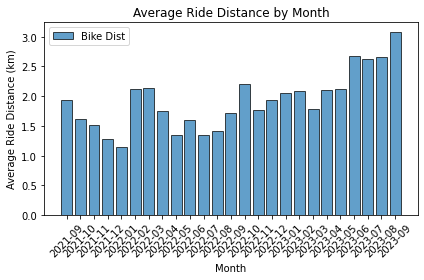

In [21]:
# Create a bar plot with 'start_date' (month) on the x-axis and 'bike_dist' on the y-axis
plt.bar(monthly_mean['month'], monthly_mean['bike_dist'], alpha=0.7, edgecolor='black', label='Bike Dist')
plt.xlabel('Month')
plt.ylabel('Average Ride Distance (km)')
plt.title('Average Ride Distance by Month')
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


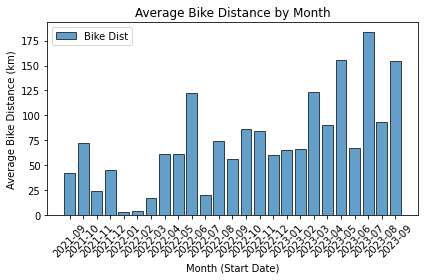

In [22]:
# Create a bar plot with 'start_date' (month) on the x-axis and 'bike_dist' on the y-axis
plt.bar(monthly_sum['month'], monthly_sum['bike_dist'], alpha=0.7, edgecolor='black', label='Bike Dist')
plt.xlabel('Month (Start Date)')
plt.ylabel('Average Bike Distance (km)')
plt.title('Average Bike Distance by Month')
plt.xticks(rotation=45)

# Show the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [23]:
from collections import Counter

station_pairs = [(trip_info['start_station'], trip_info['end_station']) for trip_info in trip_dict.values()]

# Use Counter to count the occurrences of station pairs
station_pair_counts = Counter(station_pairs)

# Find the top 5 most common station pairs and their counts
top_5_station_pairs = station_pair_counts.most_common(5)

# Print the top 5 most common station pairs and their counts
print("Top 5 most common station pairs:")
for pair, count in top_5_station_pairs:
    print(f"Station pair {pair} with {count} rides.")

Top 5 most common station pairs:
Station pair ('King St W / Charlotte St', 'Simcoe St / Wellington St W North') with 82 rides.
Station pair ('Simcoe St / Wellington St W North', 'King St W / Charlotte St') with 30 rides.
Station pair ('King St E / River St', 'King St W / Charlotte St') with 29 rides.
Station pair ('King St W / Charlotte St', 'King St E / Victoria St') with 25 rides.
Station pair ('King St W / Charlotte St', 'King St E / River St') with 19 rides.


In [ ]:
##### TORONTO OPEN DATA
### TODO Get all routes, iterate on API call and set the bounds to get 50 at a time, building a full trip history

#####
### TODO map stations to google maps coordinates

##### GOOGLE MAPS
### TODO route stations in Google Maps to get distance in meteres

##### STRAVA
### TODO https://developers.strava.com/docs/reference/

In [102]:
### GET TORONTO OPEN DATA SOURCE URL

# import requests

# # Toronto Open Data is stored in a CKAN instance. It's APIs are documented here:
# # https://docs.ckan.org/en/latest/api/

# # To hit our API, you'll be making requests to:
# base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"

# # Datasets are called "packages". Each package can contain many "resources"
# # To retrieve the metadata for this package and its resources, use the package name in this page's URL:
# url = base_url + "/api/3/action/package_show"
# params = { "id": "bike-share-toronto"}
# package = requests.get(url, params = params).json()

# # To get resource data:
# for idx, resource in enumerate(package["result"]["resources"]):

#        # To get metadata for non datastore_active resources:
#        if not resource["datastore_active"]:
#            url = base_url + "/api/3/action/resource_show?id=" + resource["id"]
#            resource_metadata = requests.get(url).json()
#            print(resource_metadata)
#            # From here, you can use the "url" attribute to download this file

# resource_metadata

In [84]:
### GET ~REALTIME BIKE STATION STATUS

# url = 'https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_status'

# res = requests.get(url).json()
# res

In [ ]:
## Random person investigating bikeshare

# blog: https://towardsdatascience.com/exploring-toronto-bike-share-ridership-using-python-3dc87d35cb62
# github: https://github.com/open-data-toronto/story-bike-share-ridership/blob/master/get_routes.ipynb